In [3]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm


info = pd.read_csv("data/info_with_type.csv")
info["date"]=pd.to_datetime(info["date"])
#info = info[info['category'] == "general"]
print(info.shape)


(39150, 7)


In [4]:
info

,pdb_id,header,smiles,seq,resolution,date,type
0,2uw1_bioml_1_FE_chains_A,oxidoreductase,[Fe],MQVTHSMPPQKLEIFKSLDDWARNNVLIHLKSVEKSWQPQDYLPDP...,1.95,2007-05-08,oxidoreductase
1,7zhz_bioml_1_BG6_chains_B,oxidoreductase,[C@@H]1([C@@H]([C@H]([C@@H]([C@H](O1)COP(=O)(O...,MSEEQSHADQDAYVADVDGILDVLRAQVLERKPDDIFQFISKSALS...,2.50,2022-12-14,oxidoreductase
2,1kjy_bioml_1_GDP_chains_A_B,signaling protein,P(=O)(O)(O)O[P@@](=O)(O)OC[C@H]1O[C@H]([C@@H](...,GAREVKLLLLGAGESGKSTIVKQMKIIHEAGYSEEECKQYKAVVYS...,2.70,2002-05-08,other
3,2c4f_bioml_1_GIL_chains_H,hydrolase,c1(cccc(c1)OC1=[N]=C(C(=C([C@H]1F)N(C(C)C)C(C)...,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,1.72,2006-10-18,hydrolase
4,8hwe_bioml_1_ATP_chains_C_D,viral protein,P(=O)(O)(O)O[P@@](=O)(O)O[P@](=O)(O)OC[C@H]1O[...,MDAAIRGNDVIFVLKTIGVPSACRQNEDPRFVEAFKCDELERYIDN...,3.30,2024-01-10,viral
...,...,...,...,...,...,...,...
39145,6h8t_bioml_1_TXY_chains_A,metal binding protein,N[C@H](C=O)CC1=CC=C([C@H](C1)O)O,IPEYVDWRQKGAVTPVKNQGSCGSCWAFSAVVTIEGIIKIRTGNLN...,2.10,2018-09-12,metal_containing
39146,2vmq_bioml_1_GLY_chains_A,transferase,NCC(=O)[O-],MKYLPQQDPQVFAAIEQERKRQHAKIELIASENFVSRAVMEAQGSV...,1.67,2008-12-16,transferase
39147,6kq1_bioml_1_HEC_chains_A,electron transport,[Fe@]123[N]4=C5C=c6n3c(=CC3=[N]2C(=Cc2n1c(C=C4...,QDGEALFKSKPCAACHSIDAKMVGPALKEVAAKYAGQEGAADLLAG...,1.57,2020-08-19,transport
39148,4g1v_bioml_1_HEM_chains_A,oxidoreductase,C1=c2c(c(c3=CC4=[N]5C(=Cc6c(c(c7C=C8C(=C(C1=[N...,MLAEKTRSIIKATVPVLEQQGTVITRTFYKNMLTEHTELLNIFNRT...,2.10,2012-11-14,oxidoreductase


In [5]:
class LigandComparer:
    def __init__(self, similarity_pkl):
        with open(similarity_pkl, "rb") as f:
            data = pickle.load(f)
        self.sim_mat = data['sim_matrix']
        self.valid_indices = data['valid_indices']
        self.index_map = {index: idx for idx, index in enumerate(self.valid_indices)}
        
    def get_sim(self, index1, index2):
        if index1 not in self.index_map or index2 not in self.index_map:
            return 0
        id1 = self.index_map[index1]
        id2 = self.index_map[index2]
        return self.sim_mat[id1, id2]
    
    def get_all_sims(self, index, list_indexes_to_compare):
        if index not in self.index_map:
            return np.zeros(len(list_indexes_to_compare))
        compare_idx = np.array([self.index_map.get(idx, np.nan) for idx in list_indexes_to_compare])
        result = np.zeros(len(list_indexes_to_compare))
        exist = ~np.isnan(compare_idx)
        result[exist] = self.sim_mat[self.index_map[index], compare_idx[exist].astype(int)]
        return result


lig_comp = LigandComparer("data/ligand_similarity_dice.pkl")

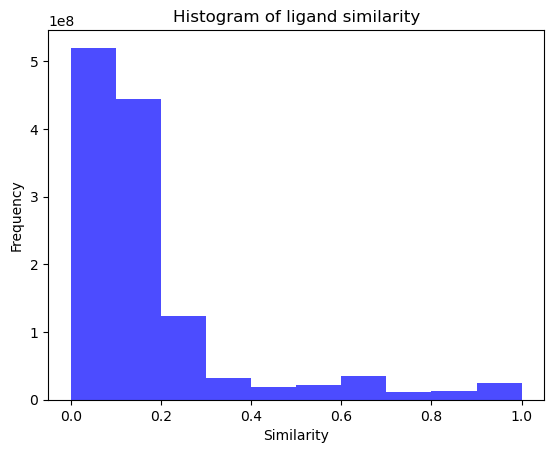

In [6]:
import matplotlib.pyplot as plt
def hist_lig_comp(lig_comp):
    plt.hist(lig_comp.sim_mat.flatten(), color='blue', alpha=0.7)
    plt.title("Histogram of ligand similarity")
    plt.xlabel("Similarity")
    plt.ylabel("Frequency")
    plt.show()


hist_lig_comp(lig_comp)

In [7]:
class ProteinComparer:
    def __init__(self, similarity_pkl):
        with open(similarity_pkl, "rb") as f:
            data = pickle.load(f)
        self.pdbid_categories = {}
        self.pdbid_map = {}
        self.similarities = {}
        for category in data:
            indices_pdbid, sim_dict = data[category]
            self.similarities[category] = sim_dict
            for idx, pdbid in enumerate(indices_pdbid):
                self.pdbid_map[pdbid] = idx
                self.pdbid_categories[pdbid] = category

    def get_category(self, pdbid):
        return self.pdbid_categories.get(pdbid, "unknown")

    def get_sim(self, pdbid1, pdbid2):
        cat1 = self.get_category(pdbid1)
        cat2 = self.get_category(pdbid2)
        if cat1 == "unknown" or cat2 == "unknown" or cat1 != cat2:
            return 0
        id1 = self.pdbid_map[pdbid1]
        id2 = self.pdbid_map[pdbid2]
        if id1 > id2:
            id1, id2 = id2, id1
        return self.similarities[cat1].get((id1, id2), 0)

    def get_all_sims(self, pdbid, list_pdbids_to_compare):
        if pdbid not in self.pdbid_map:
            return np.zeros(len(list_pdbids_to_compare))
        cat = self.get_category(pdbid)
        source_id = self.pdbid_map[pdbid]
        final_results = []
        for comp_pdbid in list_pdbids_to_compare:
            if self.get_category(comp_pdbid) != cat or comp_pdbid not in self.pdbid_map:
                final_results.append(0)
            else:
                this_idx = self.pdbid_map[comp_pdbid]
                id1, id2 = sorted([source_id, this_idx])
                if id1 == id2:
                    final_results.append(1)
                else:
                    final_results.append(self.similarities[cat].get((id1, id2), 0))
        return np.array(final_results)

prot_comp = ProteinComparer("data/protein_identities_mmseqs.pkl")


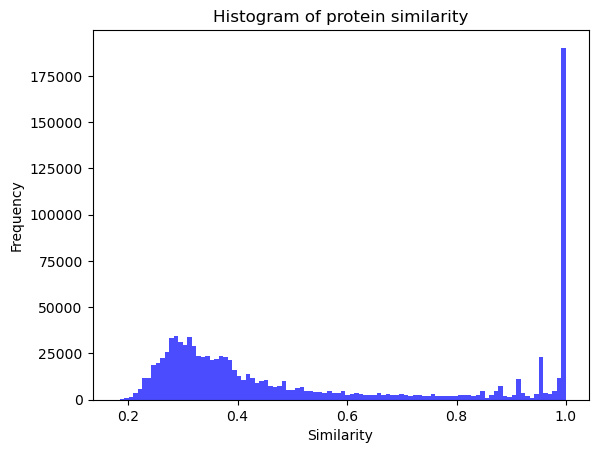

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def get_all_similarity_values(prot_comp):
    all_sim_values = []
    
    for category, sim_dict in prot_comp.similarities.items():
        sim_values = list(sim_dict.values())
        all_sim_values.extend(sim_values)
    
    return np.array(all_sim_values)

def hist_prot_comp(prot_comp):
    similarity_values = get_all_similarity_values(prot_comp)
    plt.hist(similarity_values, bins=100, color='blue', alpha=0.7)
    plt.title("Histogram of protein similarity")
    plt.xlabel("Similarity")
    plt.ylabel("Frequency")
    plt.show()

hist_prot_comp(prot_comp)

In [88]:
prot_val_cutoff = 0.2  # Белки: элемент добавляется в валидационный набор, если сходство с тестовым > 20%
prot_test_cutoff = 0.5  # Белки: элемент добавляется в тестовый набор, если сходство с ним > 50%

lig_val_cutoff = 0.4  # Лиганды: элемент добавляется в валидационный набор, если сходство с тестовым > 40%
lig_test_cutoff = 0.8  # Лиганды: элемент добавляется в тестовый набор, если сходство с ним > 80%

prot_train_val_cutoff = 0.4  # Белки: элементы удаляются из тренировочного набора, если сходство с валидационным > 20%
lig_train_val_cutoff = 0.99  # Лиганды: элементы удаляются из тренировочного набора, если сходство с валидационным > 40%


In [89]:
info.type.value_counts()

type
other               9061
transferase         8112
oxidoreductase      6515
hydrolase           6315
transport           2135
lyase               1537
membrane            1195
ligase               960
viral                787
isomerase            784
transcription        772
metal_containing     538
chaperone            439
Name: count, dtype: int64

In [90]:
# Фильтрация данных по выбранному типу и валидным индексам
selected_type = "hydrolase"
valid_indices_set = set(lig_comp.valid_indices)
type_df = info[(info['header'] == selected_type) & (info.index.isin(valid_indices_set))]


working_set = set(type_df.index)
train = set()
val = set()
test = set()

test_working = set(type_df.sample(5).index)
test = set(test_working)

print("Initial test set size:", len(test))

while len(test_working) > 0:
    test_new_round = set()
    
    working_set -= test_working
    for item in test_working:
        wlist = np.array(list(working_set))
        prot_sims = prot_comp.get_all_sims(item, wlist)
        lig_sims = lig_comp.get_all_sims(item, wlist)
        strict_criterion_selected = (prot_sims > prot_test_cutoff) | (lig_sims > lig_test_cutoff)
        add_to_test = wlist[strict_criterion_selected]

        working_set -= set(add_to_test)
        test |= set(add_to_test)
        test_new_round |= set(add_to_test)

        wlist = np.array(list(working_set))
        prot_sims = prot_comp.get_all_sims(item, wlist)
        lig_sims = lig_comp.get_all_sims(item, wlist)

        loose_criterion_selected = (prot_sims > prot_val_cutoff) | (lig_sims > lig_val_cutoff)
        add_to_val = wlist[loose_criterion_selected]

        working_set -= set(add_to_val)
        val |= set(add_to_val)

    test_working = test_new_round
    print(len(working_set), len(val), len(test), len(test_working))

print("="*50)
# now remove anything in train that is too similar to val
val_working = val.copy()
while len(val_working) > 0:
    val_new_round = set()
    working_set -= val_working
    for item in val_working:
        wlist = np.array(list(working_set))
        prot_sims = prot_comp.get_all_sims(item, wlist)
        lig_sims = lig_comp.get_all_sims(item, wlist)
        criterion_selected = (prot_sims > prot_train_val_cutoff) | (lig_sims > lig_train_val_cutoff)
        add_to_val = wlist[criterion_selected]

        working_set -= set(add_to_val)
        val |= set(add_to_val)
        val_new_round |= set(add_to_val)
    val_working = val_new_round
    print(len(working_set), len(val), len(test), len(val_working))

print(selected_type)
print(f"Train: {len(working_set)}, Val: {len(val)}, Test: {len(test)}")


Initial test set size: 5
3140 662 976 971
2998 804 976 0
2998 804 976 0
hydrolase
Train: 2998, Val: 804, Test: 976


In [91]:
train_indices = list(working_set)
val_indices = list(val)
test_indices = list(test)

len(train_indices), len(val_indices), len(test_indices)


(2998, 804, 976)

Computing ligand similarity test-val: 100%|██████████| 976/976 [00:00<00:00, 4713.92it/s]


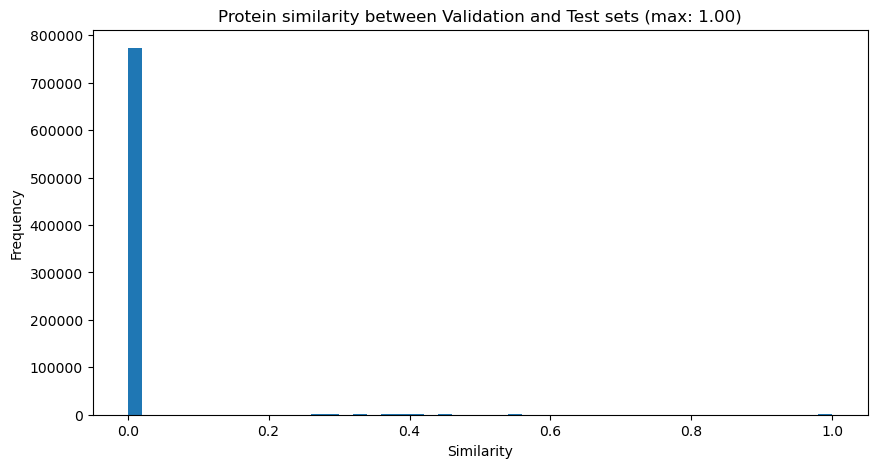

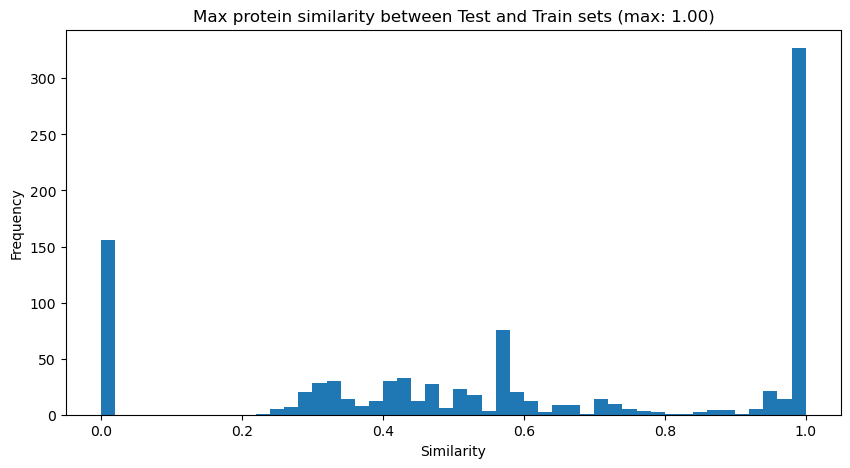

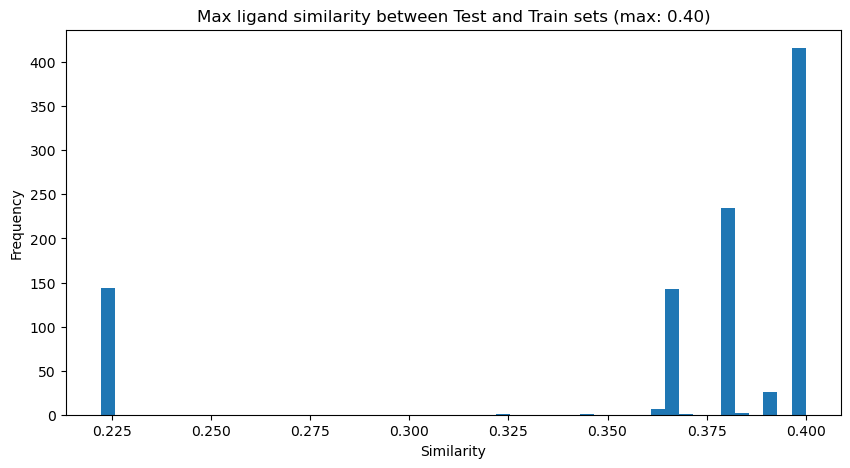

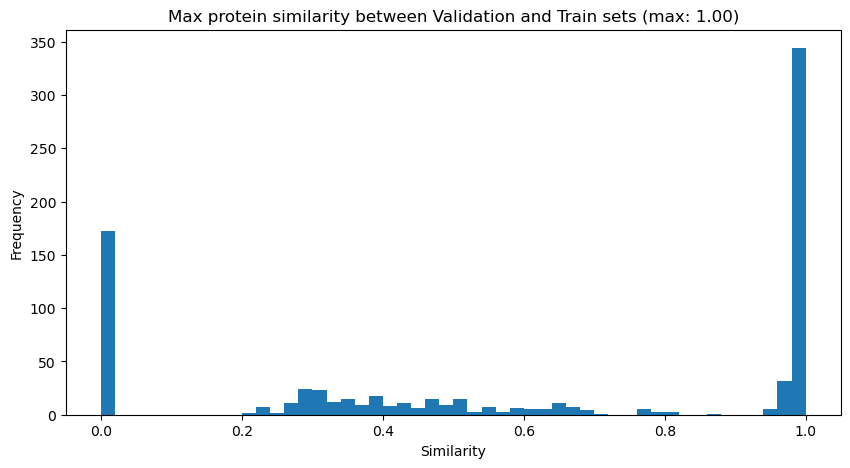

In [92]:

def compute_similarity_matrix(ids_a, ids_b, comp_func, desc, id_type='index'):
    sim_matrix = np.zeros((len(ids_a), len(ids_b)))
    for idx, id_a in enumerate(tqdm(ids_a, desc=desc)):
        sim_matrix[idx, :] = comp_func(id_a, ids_b)
    return sim_matrix

test_pdbids = info.loc[test_indices, 'pdb_id'].tolist()
train_pdbids = info.loc[train_indices, 'pdb_id'].tolist()
val_pdbids = info.loc[val_indices, 'pdb_id'].tolist()

# Вычисление матриц схожести
prot_sim_train_test = compute_similarity_matrix(test_pdbids, train_pdbids, prot_comp.get_all_sims, "Computing protein similarity test-train")
lig_sim_train_test = compute_similarity_matrix(test_indices, train_indices, lig_comp.get_all_sims, "Computing ligand similarity test-train")

prot_sim_train_val = compute_similarity_matrix(val_pdbids, train_pdbids, prot_comp.get_all_sims, "Computing protein similarity val-train")
lig_sim_train_val = compute_similarity_matrix(val_indices, train_indices, lig_comp.get_all_sims, "Computing ligand similarity val-train")

prot_sim_val_test = compute_similarity_matrix(test_pdbids, val_pdbids, prot_comp.get_all_sims, "Computing protein similarity test-val")
lig_sim_val_test = compute_similarity_matrix(test_indices, val_indices, lig_comp.get_all_sims, "Computing ligand similarity test-val")
# Максимальная схожесть
max_prot_sim_test_to_train = np.max(prot_sim_train_test, axis=1)
max_lig_sim_test_to_train = np.max(lig_sim_train_test, axis=1)

max_prot_sim_val_to_train = np.max(prot_sim_train_val, axis=1)
max_lig_sim_val_to_train = np.max(lig_sim_train_val, axis=1)

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.hist(prot_sim_val_test.flatten(), bins=50)
plt.title(f"Protein similarity between Validation and Test sets (max: {np.max(prot_sim_val_test):.2f})")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(max_prot_sim_test_to_train, bins=50)
plt.title(f"Max protein similarity between Test and Train sets (max: {np.max(max_prot_sim_test_to_train):.2f})")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(max_lig_sim_test_to_train, bins=50)
plt.title(f"Max ligand similarity between Test and Train sets (max: {np.max(max_lig_sim_test_to_train):.2f})")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(max_prot_sim_val_to_train, bins=50)
plt.title(f"Max protein similarity between Validation and Train sets (max: {np.max(max_prot_sim_val_to_train):.2f})")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.show()




In [93]:
split_dict = {}

# Добавление разбиения для выбранного типа белков
split_dict[selected_type] = {
    "train": train_indices,
    "val": val_indices,
    "test": test_indices
}


In [94]:
all_trains = np.array(split_dict[selected_type]["train"])
all_vals = np.array(split_dict[selected_type]["val"])
all_tests = np.array(split_dict[selected_type]["test"])

print(f"Total sizes - Train: {len(all_trains)}, Validation: {len(all_vals)}, Test: {len(all_tests)}")


Total sizes - Train: 2998, Validation: 804, Test: 976


In [95]:

# Расчет схожести между объединенными наборами
print("Computing similarities between combined sets...")
prot_sim_test_train = compute_similarity_matrix(all_tests, all_trains, prot_comp.get_all_sims, "Protein similarity test-train")
lig_sim_test_train = compute_similarity_matrix(all_tests, all_trains, lig_comp.get_all_sims, "Ligand similarity test-train")

prot_sim_val_train = compute_similarity_matrix(all_vals, all_trains, prot_comp.get_all_sims, "Protein similarity val-train")
lig_sim_val_train = compute_similarity_matrix(all_vals, all_trains, lig_comp.get_all_sims, "Ligand similarity val-train")

# Максимальная схожесть
max_prot_sim_train_to_test = np.max(prot_sim_test_train, axis=0)
max_lig_sim_train_to_test = np.max(lig_sim_test_train, axis=0)

max_prot_sim_train_to_val = np.max(prot_sim_val_train, axis=0)
max_lig_sim_train_to_val = np.max(lig_sim_val_train, axis=0)

# Фильтрация тренировочного набора по максимальной схожести
print("Filtering training set based on maximum ligand similarity thresholds...")
filtered_train = all_trains[(max_lig_sim_train_to_test < 0.99) & (max_lig_sim_train_to_val < 0.99)]

# Обновление DataFrame info с новыми разбиениями
info['new_split'] = None
info.loc[filtered_train, 'new_split'] = "train"
info.loc[all_vals, 'new_split'] = "val"
info.loc[all_tests, 'new_split'] = "test"

print("Data splitting and filtering completed.")
print("Final counts:")
print(info['new_split'].value_counts())

Computing similarities between combined sets...


Ligand similarity val-train: 100%|██████████| 804/804 [00:00<00:00, 1023.10it/s]

Filtering training set based on maximum ligand similarity thresholds...
Data splitting and filtering completed.
Final counts:
new_split
train    2998
test      976
val       804
Name: count, dtype: int64


In [96]:
info

,pdb_id,header,smiles,seq,resolution,date,type,new_split
0,2uw1_bioml_1_FE_chains_A,oxidoreductase,[Fe],MQVTHSMPPQKLEIFKSLDDWARNNVLIHLKSVEKSWQPQDYLPDP...,1.95,2007-05-08,oxidoreductase,None
1,7zhz_bioml_1_BG6_chains_B,oxidoreductase,[C@@H]1([C@@H]([C@H]([C@@H]([C@H](O1)COP(=O)(O...,MSEEQSHADQDAYVADVDGILDVLRAQVLERKPDDIFQFISKSALS...,2.50,2022-12-14,oxidoreductase,None
2,1kjy_bioml_1_GDP_chains_A_B,signaling protein,P(=O)(O)(O)O[P@@](=O)(O)OC[C@H]1O[C@H]([C@@H](...,GAREVKLLLLGAGESGKSTIVKQMKIIHEAGYSEEECKQYKAVVYS...,2.70,2002-05-08,other,None
3,2c4f_bioml_1_GIL_chains_H,hydrolase,c1(cccc(c1)OC1=[N]=C(C(=C([C@H]1F)N(C(C)C)C(C)...,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,1.72,2006-10-18,hydrolase,None
4,8hwe_bioml_1_ATP_chains_C_D,viral protein,P(=O)(O)(O)O[P@@](=O)(O)O[P@](=O)(O)OC[C@H]1O[...,MDAAIRGNDVIFVLKTIGVPSACRQNEDPRFVEAFKCDELERYIDN...,3.30,2024-01-10,viral,None
...,...,...,...,...,...,...,...,...
39145,6h8t_bioml_1_TXY_chains_A,metal binding protein,N[C@H](C=O)CC1=CC=C([C@H](C1)O)O,IPEYVDWRQKGAVTPVKNQGSCGSCWAFSAVVTIEGIIKIRTGNLN...,2.10,2018-09-12,metal_containing,None
39146,2vmq_bioml_1_GLY_chains_A,transferase,NCC(=O)[O-],MKYLPQQDPQVFAAIEQERKRQHAKIELIASENFVSRAVMEAQGSV...,1.67,2008-12-16,transferase,None
39147,6kq1_bioml_1_HEC_chains_A,electron transport,[Fe@]123[N]4=C5C=c6n3c(=CC3=[N]2C(=Cc2n1c(C=C4...,QDGEALFKSKPCAACHSIDAKMVGPALKEVAAKYAGQEGAADLLAG...,1.57,2020-08-19,transport,None
39148,4g1v_bioml_1_HEM_chains_A,oxidoreductase,C1=c2c(c(c3=CC4=[N]5C(=Cc6c(c(c7C=C8C(=C(C1=[N...,MLAEKTRSIIKATVPVLEQQGTVITRTFYKNMLTEHTELLNIFNRT...,2.10,2012-11-14,oxidoreductase,None


In [97]:
split_dict = {}

# Проходим по всем типам из info['type']
for selected_type in info['type'].unique():
    print(f"Processing type: {selected_type}")

    # Фильтрация данных по текущему типу и валидным индексам
    valid_indices_set = set(lig_comp.valid_indices)
    type_df = info[(info['type'] == selected_type) & (info.index.isin(valid_indices_set))]

    if len(type_df) < 5:
        print(f"Skipping type {selected_type} due to insufficient data.")
        continue

    working_set = set(type_df.index)

    train = set()
    val = set()
    test = set()

    # Выбор тестовых данных
    test_working = set(type_df.sample(5, random_state=42).index)
    test.update(test_working)

    while len(test_working) > 0:
        test_new_round = set()
        working_set -= test_working

        for item in test_working:
            wlist = np.array(list(working_set))
            prot_sims = prot_comp.get_all_sims(item, wlist)
            lig_sims = lig_comp.get_all_sims(item, wlist)

            strict_criterion_selected = (prot_sims > prot_test_cutoff) | (lig_sims > lig_test_cutoff)
            add_to_test = wlist[strict_criterion_selected]

            working_set -= set(add_to_test)
            test |= set(add_to_test)
            test_new_round |= set(add_to_test)

            loose_criterion_selected = (prot_sims > prot_val_cutoff) | (lig_sims > lig_val_cutoff)
            add_to_val = wlist[loose_criterion_selected]

            working_set -= set(add_to_val)
            val |= set(add_to_val)

        test_working = test_new_round

    val_working = val.copy()
    while len(val_working) > 0:
        val_new_round = set()
        working_set -= val_working

        for item in val_working:
            wlist = np.array(list(working_set))
            prot_sims = prot_comp.get_all_sims(item, wlist)
            lig_sims = lig_comp.get_all_sims(item, wlist)

            criterion_selected = (prot_sims > prot_train_val_cutoff) | (lig_sims > lig_train_val_cutoff)
            add_to_val = wlist[criterion_selected]

            working_set -= set(add_to_val)
            val |= set(add_to_val)
            val_new_round |= set(add_to_val)

        val_working = val_new_round

    print(f"Type: {selected_type}, Train: {len(working_set)}, Val: {len(val)}, Test: {len(test)}")

    train_indices = list(working_set)
    val_indices = list(val)
    test_indices = list(test)

    # Добавление разбиения для текущего типа
    split_dict[selected_type] = {
        "train": train_indices,
        "val": val_indices,
        "test": test_indices
    }

    # Вычисление метрик схожести (опционально)
    prot_sim_test_train = compute_similarity_matrix(
        info.loc[test_indices, 'pdb_id'].tolist(),
        info.loc[train_indices, 'pdb_id'].tolist(),
        prot_comp.get_all_sims,
        f"Protein similarity {selected_type} test-train"
    )

    print(f"Completed type: {selected_type}")

# Обновление DataFrame info с новыми разбиениями
info['new_split'] = None
for split_type, indices in split_dict.items():
    info.loc[indices['train'], 'new_split'] = f"train"
    info.loc[indices['val'], 'new_split'] = f"val"
    info.loc[indices['test'], 'new_split'] = f"test"




Processing type: oxidoreductase
Type: oxidoreductase, Train: 2589, Val: 3676, Test: 1547


Protein similarity oxidoreductase test-train: 100%|██████████| 1547/1547 [00:03<00:00, 489.59it/s]


Completed type: oxidoreductase
Processing type: other
Type: other, Train: 4657, Val: 3047, Test: 1094


Protein similarity other test-train: 100%|██████████| 1094/1094 [00:00<00:00, 50593.96it/s]

Completed type: other
Processing type: hydrolase


Type: hydrolase, Train: 4546, Val: 1191, Test: 659


Protein similarity hydrolase test-train: 100%|██████████| 659/659 [00:02<00:00, 282.12it/s]


Completed type: hydrolase
Processing type: viral
Type: viral, Train: 611, Val: 133, Test: 63


Protein similarity viral test-train: 100%|██████████| 63/63 [00:00<00:00, 2516.32it/s]


Completed type: viral
Processing type: transferase
Type: transferase, Train: 3112, Val: 3723, Test: 1390


Protein similarity transferase test-train: 100%|██████████| 1390/1390 [00:03<00:00, 377.12it/s]


Completed type: transferase
Processing type: membrane
Type: membrane, Train: 856, Val: 290, Test: 173


Protein similarity membrane test-train: 100%|██████████| 173/173 [00:00<00:00, 1681.91it/s]

Completed type: membrane
Processing type: lyase


Type: lyase, Train: 1101, Val: 398, Test: 72


Protein similarity lyase test-train: 100%|██████████| 72/72 [00:00<00:00, 1427.06it/s]

Completed type: lyase
Processing type: ligase


Type: ligase, Train: 289, Val: 600, Test: 430


Protein similarity ligase test-train: 100%|██████████| 430/430 [00:00<00:00, 5373.72it/s]

Completed type: ligase
Processing type: transport


Type: transport, Train: 1496, Val: 528, Test: 26


Protein similarity transport test-train: 100%|██████████| 26/26 [00:00<00:00, 855.72it/s]


Completed type: transport
Processing type: isomerase
Type: isomerase, Train: 667, Val: 65, Test: 39


Protein similarity isomerase test-train: 100%|██████████| 39/39 [00:00<00:00, 2425.93it/s]

Completed type: isomerase
Processing type: transcription


Type: transcription, Train: 477, Val: 226, Test: 82


Protein similarity transcription test-train: 100%|██████████| 82/82 [00:00<00:00, 2889.10it/s]


Completed type: transcription
Processing type: metal_containing
Type: metal_containing, Train: 476, Val: 34, Test: 35


Protein similarity metal_containing test-train: 100%|██████████| 35/35 [00:00<00:00, 3250.39it/s]


Completed type: metal_containing
Processing type: chaperone
Type: chaperone, Train: 138, Val: 279, Test: 234


Protein similarity chaperone test-train: 100%|██████████| 234/234 [00:00<00:00, 11092.15it/s]

Completed type: chaperone


In [98]:
print("Data splitting and filtering completed for all types.")
print("Final counts:")
info['new_split'].value_counts()

Data splitting and filtering completed for all types.
Final counts:


new_split
train    21015
val       8411
test      5844
Name: count, dtype: int64

In [99]:
info

,pdb_id,header,smiles,seq,resolution,date,type,new_split
0,2uw1_bioml_1_FE_chains_A,oxidoreductase,[Fe],MQVTHSMPPQKLEIFKSLDDWARNNVLIHLKSVEKSWQPQDYLPDP...,1.95,2007-05-08,oxidoreductase,test
1,7zhz_bioml_1_BG6_chains_B,oxidoreductase,[C@@H]1([C@@H]([C@H]([C@@H]([C@H](O1)COP(=O)(O...,MSEEQSHADQDAYVADVDGILDVLRAQVLERKPDDIFQFISKSALS...,2.50,2022-12-14,oxidoreductase,train
2,1kjy_bioml_1_GDP_chains_A_B,signaling protein,P(=O)(O)(O)O[P@@](=O)(O)OC[C@H]1O[C@H]([C@@H](...,GAREVKLLLLGAGESGKSTIVKQMKIIHEAGYSEEECKQYKAVVYS...,2.70,2002-05-08,other,None
3,2c4f_bioml_1_GIL_chains_H,hydrolase,c1(cccc(c1)OC1=[N]=C(C(=C([C@H]1F)N(C(C)C)C(C)...,IVGGKVCPKGECPWQVLLLVNGAQLCGGTLINTIWVVSAAHCFDKI...,1.72,2006-10-18,hydrolase,None
4,8hwe_bioml_1_ATP_chains_C_D,viral protein,P(=O)(O)(O)O[P@@](=O)(O)O[P@](=O)(O)OC[C@H]1O[...,MDAAIRGNDVIFVLKTIGVPSACRQNEDPRFVEAFKCDELERYIDN...,3.30,2024-01-10,viral,train
...,...,...,...,...,...,...,...,...
39145,6h8t_bioml_1_TXY_chains_A,metal binding protein,N[C@H](C=O)CC1=CC=C([C@H](C1)O)O,IPEYVDWRQKGAVTPVKNQGSCGSCWAFSAVVTIEGIIKIRTGNLN...,2.10,2018-09-12,metal_containing,train
39146,2vmq_bioml_1_GLY_chains_A,transferase,NCC(=O)[O-],MKYLPQQDPQVFAAIEQERKRQHAKIELIASENFVSRAVMEAQGSV...,1.67,2008-12-16,transferase,train
39147,6kq1_bioml_1_HEC_chains_A,electron transport,[Fe@]123[N]4=C5C=c6n3c(=CC3=[N]2C(=Cc2n1c(C=C4...,QDGEALFKSKPCAACHSIDAKMVGPALKEVAAKYAGQEGAADLLAG...,1.57,2020-08-19,transport,val
39148,4g1v_bioml_1_HEM_chains_A,oxidoreductase,C1=c2c(c(c3=CC4=[N]5C(=Cc6c(c(c7C=C8C(=C(C1=[N...,MLAEKTRSIIKATVPVLEQQGTVITRTFYKNMLTEHTELLNIFNRT...,2.10,2012-11-14,oxidoreductase,train


In [100]:
info.to_csv("data/info_with_type_split.csv")

In [101]:
!ls /mnt/ligandpro/db/LPCE/info_with_type_split.csv

/mnt/ligandpro/db/LPCE/info_with_type_split.csv


In [103]:
!cp data/info_with_type_split.csv /mnt/ligandpro/db/LPCE/info_with_type_split.csv

In [102]:
!ls /mnt/ligandpro/db/LPCE/with_trash/final/

11gs_bioml_1_GSH_chains_A_B	     5hr5_bioml_1_ADP_chains_A
12as_bioml_1_ASN_chains_A	     5hsa_bioml_1_PGE_chains_A_C_F
12gs_bioml_1_0HH_chains_A_B	     5hsa_bioml_1_PGE_chains_A_E
13gs_bioml_1_GSH_chains_A_B	     5hsf_bioml_1_PGE_chains_A
13pk_bioml_1_MG_chains_A	     5hsj_bioml_1_PLP_chains_A_B
148l_bioml_1_MUB_chains_E_S	     5ht0_bioml_1_COA_chains_A_B
155c_bioml_1_HEM_chains_A	     5htc_bioml_1_66M_chains_A_C
17gs_bioml_1_GTX_chains_A_B	     5htk_bioml_1_ATP_chains_A
19gs_bioml_1_BSP_chains_A	     5htx_bioml_1_ADP_chains_A
19hc_bioml_1_HEM_chains_A	     5hu3_bioml_1_ADP_chains_A
1a05_bioml_1_MG_chains_A_B	     5hu6_bioml_1_HEM_chains_B_D
1a0f_bioml_1_GTS_chains_A_B	     5hu9_bioml_1_66K_chains_A
1a0i_bioml_1_ATP_chains_A	     5hua_bioml_1_FK5_chains_A
1a25_bioml_1_PSE_chains_B	     5hud_bioml_1_PGE_chains_E
1a28_bioml_1_STR_chains_A	     5hud_bioml_1_TRP_chains_A_D
1a2s_bioml_1_HEC_chains_A	     5hud_bioml_1_TRP_chains_B_C
1a47_bioml_1_ADH_chains_A	     5hue_bioml_1_TRP_chains_A
1